In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, countDistinct

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import min, max

import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType, BooleanType

In [2]:
spark = SparkSession.builder \
    .appName("EDA on Mips Procedure Volume Data") \
    .getOrCreate()


24/09/23 18:16:46 WARN Utils: Your hostname, sahils-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.10.15.90 instead (on interface en0)
24/09/23 18:16:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/23 18:16:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet("sample-data/doctorright-datalake/hive_metastore.mips_data.procedurevolume.parquet")
df.printSchema()

root
 |-- NPI: integer (nullable = true)
 |-- Ind_PAC_ID: long (nullable = true)
 |-- Provider_Last_Name: string (nullable = true)
 |-- Provider_First_Name: string (nullable = true)
 |-- Provider_Middle_Name: string (nullable = true)
 |-- suff: string (nullable = true)
 |-- Procedure_Category: string (nullable = true)
 |-- Count: string (nullable = true)
 |-- Percentile: integer (nullable = true)
 |-- Profile_Display_Indicator: string (nullable = true)



24/09/23 18:17:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [19]:
df.show(5)

+----------+----------+------------------+-------------------+--------------------+----+--------------------+-----+----------+-------------------------+
|       NPI|Ind_PAC_ID|Provider_Last_Name|Provider_First_Name|Provider_Middle_Name|suff|  Procedure_Category|Count|Percentile|Profile_Display_Indicator|
+----------+----------+------------------+-------------------+--------------------+----+--------------------+-----+----------+-------------------------+
|1407896475|9436187630|         GILIBERTI|             ORAZIO|                   L|NULL|    Cataract surgery|   82|        51|                        Y|
|1407897259|4486606290|             SALIM|           MUHAMMAD|                NULL|NULL|Coronary angiopla...|   78|        87|                        Y|
|1407897259|4486606290|             SALIM|           MUHAMMAD|                NULL|NULL|Pacemaker inserti...|   19|        69|                        Y|
|1407897333|4284624495|            KANSAL|           NARENDRA|                NULL

In [7]:
df.describe().show()

24/09/23 16:30:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+------------------+-------------------+--------------------+----+------------------+------------------+------------------+-------------------------+
|summary|                 NPI|          Ind_PAC_ID|Provider_Last_Name|Provider_First_Name|Provider_Middle_Name|suff|Procedure_Category|             Count|        Percentile|Profile_Display_Indicator|
+-------+--------------------+--------------------+------------------+-------------------+--------------------+----+------------------+------------------+------------------+-------------------------+
|  count|              146830|              146830|            146830|             146830|              105553|4357|            146830|            146830|             84471|                   146830|
|   mean|1.4990020628288293E9| 4.989287104569938E9|               NaN|                NaN|                NULL|NULL|              NULL|119.69468811781559| 67.60664606788129|                     NULL|


Questions:
1. What is stuff?
2. What is count? Context? Count of what?

In [8]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----------+------------------+-------------------+--------------------+------+------------------+-----+----------+-------------------------+
|NPI|Ind_PAC_ID|Provider_Last_Name|Provider_First_Name|Provider_Middle_Name|  suff|Procedure_Category|Count|Percentile|Profile_Display_Indicator|
+---+----------+------------------+-------------------+--------------------+------+------------------+-----+----------+-------------------------+
|  0|         0|                 1|                  5|               41277|142473|                 0|    0|     62359|                        0|
+---+----------+------------------+-------------------+--------------------+------+------------------+-----+----------+-------------------------+



In [9]:
df.dtypes

[('NPI', 'int'),
 ('Ind_PAC_ID', 'bigint'),
 ('Provider_Last_Name', 'string'),
 ('Provider_First_Name', 'string'),
 ('Provider_Middle_Name', 'string'),
 ('suff', 'string'),
 ('Procedure_Category', 'string'),
 ('Count', 'string'),
 ('Percentile', 'int'),
 ('Profile_Display_Indicator', 'string')]

In [5]:
numeric_columns = [col for col, type in df.dtypes if type in ["int", "bigint", "float", "double"]]
numeric_columns

['NPI', 'Ind_PAC_ID', 'Percentile']

# EDA

In [12]:
provider_count = df.groupBy("Procedure_Category") \
    .agg({"NPI": "count"}) \
    .withColumnRenamed("count(NPI)", "Provider_Count")

provider_count.show()


+--------------------+--------------+
|  Procedure_Category|Provider_Count|
+--------------------+--------------+
|    Knee replacement|         12652|
|     Hip replacement|         11691|
|Pacemaker inserti...|         12632|
|         Colonoscopy|         26674|
|Coronary angiopla...|          9429|
|  Prostate resection|          8276|
|    Cataract surgery|         17881|
|       Spinal fusion|         10599|
|          Mastectomy|         10813|
|Hernia repair – g...|         12657|
|Coronary artery b...|          3112|
|Hernia repair (mi...|         10414|
+--------------------+--------------+



In [13]:
from pyspark.sql.functions import col

top_providers = df.groupBy("Provider_Last_Name", "Provider_First_Name") \
    .agg({"Count": "sum"}) \
    .withColumnRenamed("sum(Count)", "Total_Count") \
    .orderBy(col("Total_Count").desc())

top_providers.show(10)


+------------------+-------------------+-----------+
|Provider_Last_Name|Provider_First_Name|Total_Count|
+------------------+-------------------+-----------+
|            CONLEY|               RYAN|     8144.0|
|            SHULTZ|            WILLIAM|     6515.0|
|           GRAYSON|            DOUGLAS|     4605.0|
|             WORTZ|               GARY|     4166.0|
|            WALTON|               PAUL|     4138.0|
|            FOSTER|               JOHN|     3990.0|
|              FORD|             ROBERT|     3952.0|
|              LONG|             KUUMBA|     3905.0|
|           IRELAND|           KIMBERLY|     3779.0|
|          ANDERSON|             STEVEN|     3634.0|
+------------------+-------------------+-----------+
only showing top 10 rows



In [14]:
percentile_analysis = df.groupBy("Percentile") \
    .agg({"NPI": "count"}) \
    .withColumnRenamed("count(NPI)", "Provider_Count")

percentile_analysis.show()


+----------+--------------+
|Percentile|Provider_Count|
+----------+--------------+
|        31|           491|
|        85|          1566|
|        65|          1399|
|        53|           773|
|        78|          1347|
|        34|           494|
|        81|          1428|
|        28|           373|
|        76|          1334|
|        27|           320|
|        26|           485|
|        44|           890|
|        91|          1366|
|        22|           196|
|        93|          1378|
|        47|          1030|
|      NULL|         62359|
|        52|          1181|
|        86|          1536|
|        40|          1011|
+----------+--------------+
only showing top 20 rows



In [15]:
profile_distribution = df.groupBy("Profile_Display_Indicator") \
    .agg({"NPI": "count"}) \
    .withColumnRenamed("count(NPI)", "Provider_Count")

profile_distribution.show()


+-------------------------+--------------+
|Profile_Display_Indicator|Provider_Count|
+-------------------------+--------------+
|                        Y|        141827|
|                        N|          5003|
+-------------------------+--------------+



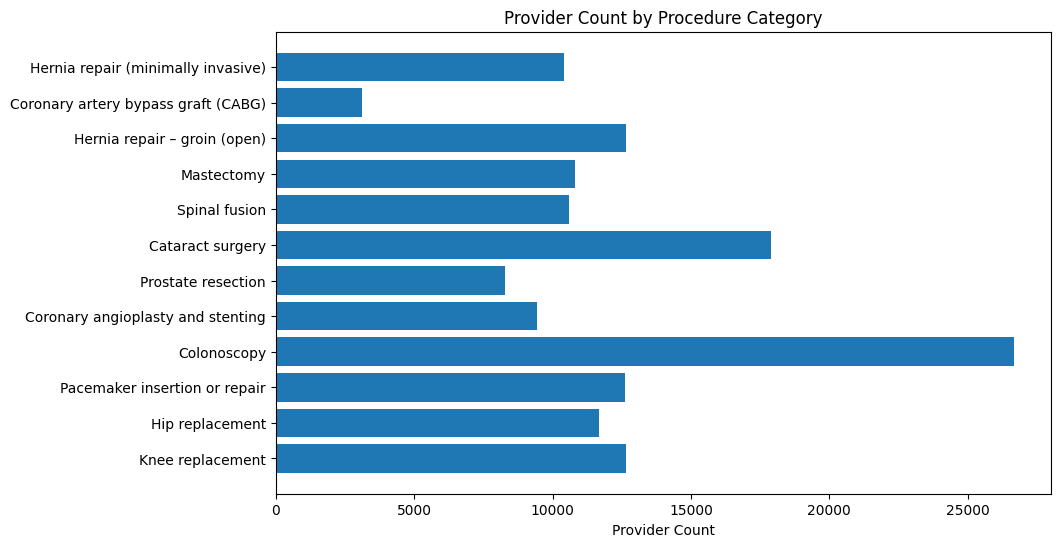

In [16]:
provider_count_pd = provider_count.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(provider_count_pd['Procedure_Category'], provider_count_pd['Provider_Count'])
plt.xlabel('Provider Count')
plt.title('Provider Count by Procedure Category')
plt.show()

# Data Distribution Analysis

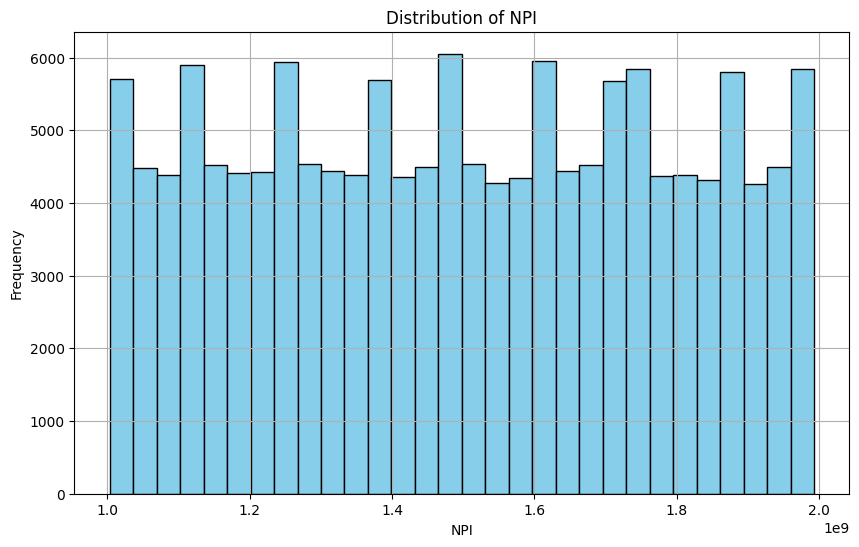

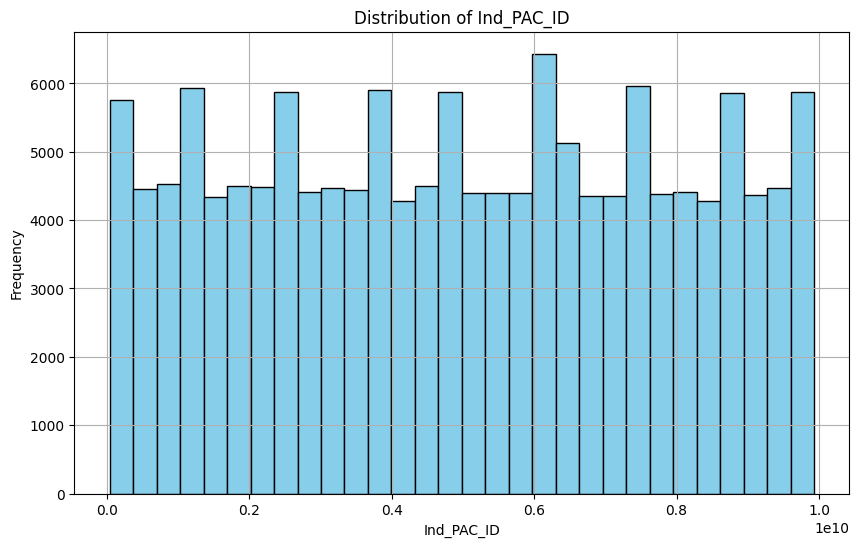

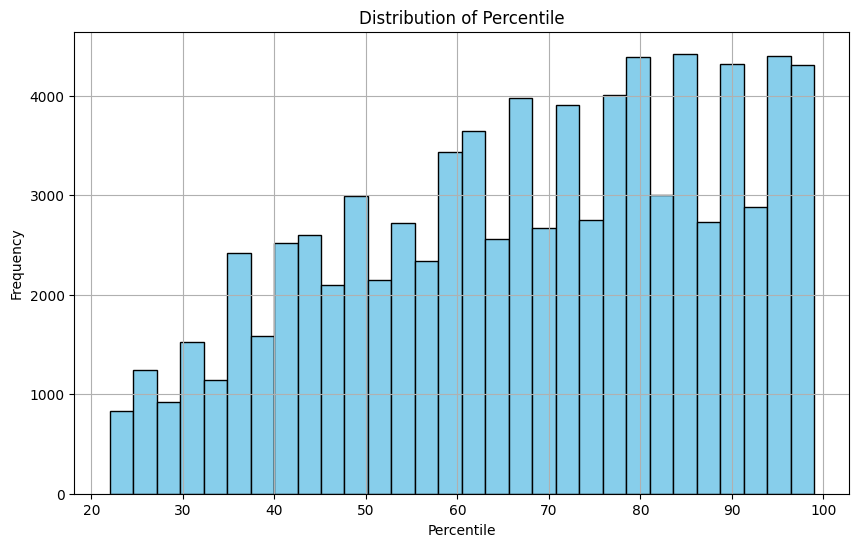

In [6]:

pandas_df = df.select(numeric_columns).toPandas()

for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.hist(pandas_df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Outlier Analysis

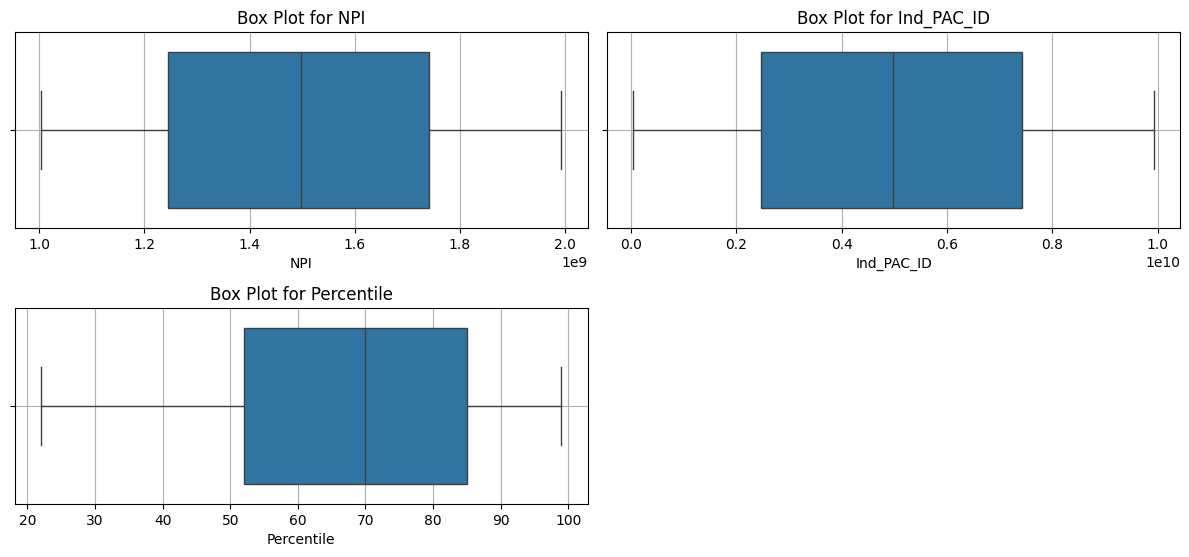

In [17]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw box plots for each numeric column
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)  # Create a subplot for each column
    sns.boxplot(x=pandas_df[col])
    plt.title(f'Box Plot for {col}')
    plt.grid(True)

plt.tight_layout()
plt.show()